# Topic Distinctness (Structural Quality)

Score = 1 − mean(similarity) with similarity in [0,1]. High score ⇒ labels are semantically distinct.
**Note:** High distinctness does not imply interpretability; we need to pair with human/LLM judgment for meaning later. 

In [1]:
import json
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer

sns.set_theme(style="whitegrid")

EMBEDDING_MODEL = "all-MiniLM-L6-v2"
DATA_ROOT = Path("../data_out")
# DATA_ROOT = Path("../data_out/data_out")
CACHE_DIR = Path("../data_out/distinctness_embedding_cache")
N_DOCS = 800  # only run experiments with this many documents
TOP_K_SIMILAR = 5
LABEL_TRUNCATE = 25

# All experiment dirs with N_DOCS in name and summary.json
exp_dirs = sorted(
    d for d in DATA_ROOT.iterdir()
    if d.is_dir() and f"_{N_DOCS}_" in d.name and (d / "summary.json").exists()
)
print(f"Found {len(exp_dirs)} experiments: {[d.name for d in exp_dirs]}")

/Users/nityaakalra/Desktop/nyt_topic_modeling/topic_modeling_paper/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 4 experiments: ['GenAIMethodOneShotNoPrior_800_custom_data_gpt-4o-mini_equal', 'GenAIMethodOneShotNoPrior_800_custom_data_gpt-4o_equal', 'GenAIMethodOneShotNoPrior_800_custom_data_gpt-5-mini_equal', 'GenAIMethodOneShotNoPrior_800_custom_data_gpt-5.2_equal']


In [2]:
def normalize_label(s: str) -> str:
    s = s.lower().strip()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def canonicalize_topics(raw_list):
    seen = set()
    out = []
    for t in raw_list:
        n = normalize_label(t)
        if n and n not in seen:
            seen.add(n)
            out.append(t)
    return out

# Load run_topics for every experiment
all_run_topics = {}
for exp_dir in exp_dirs:
    with open(exp_dir / "summary.json") as f:
        summary = json.load(f)
    runs = summary["runs"]
    all_run_topics[exp_dir.name] = {
        r["run_number"]: canonicalize_topics(r["topics"]) for r in runs
    }
print("Experiments loaded:", list(all_run_topics.keys()))

Experiments loaded: ['GenAIMethodOneShotNoPrior_800_custom_data_gpt-4o-mini_equal', 'GenAIMethodOneShotNoPrior_800_custom_data_gpt-4o_equal', 'GenAIMethodOneShotNoPrior_800_custom_data_gpt-5-mini_equal', 'GenAIMethodOneShotNoPrior_800_custom_data_gpt-5.2_equal']


In [3]:
CACHE_DIR.mkdir(parents=True, exist_ok=True)
model = SentenceTransformer(EMBEDDING_MODEL)

def get_embeddings(labels, cache_key, exp_name):
    cache_path = CACHE_DIR / f"{exp_name}_{cache_key}.npy"
    if cache_path.exists():
        return np.load(cache_path)
    emb = model.encode(labels, normalize_embeddings=True)
    np.save(cache_path, emb)
    return emb

run_embeddings = {}
for exp_name, run_topics in all_run_topics.items():
    run_embeddings[exp_name] = {}
    for run_id, topics in run_topics.items():
        run_embeddings[exp_name][run_id] = get_embeddings(topics, f"run{run_id}", exp_name)

In [4]:
def pairwise_similarity_01(emb):
    """emb: (n, d) L2-normalized. Returns (n,n) with cos in [0,1]: s_01 = (cos+1)/2."""
    cos = emb @ emb.T
    np.clip(cos, -1.0, 1.0, out=cos)
    return (cos + 1) / 2

def distinctness_and_stats(emb, labels, top_k=5):
    n = len(labels)
    sim = pairwise_similarity_01(emb)
    upper = np.triu_indices(n, k=1)
    vals = sim[upper]
    if len(vals) == 0:
        return {"distinctness": np.nan, "mean_sim": np.nan, "median_sim": np.nan,
                "min_sim": np.nan, "max_sim": np.nan, "k": n, "top_pairs": []}
    distinctness = 1 - float(np.mean(vals))
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            pairs.append((i, j, sim[i, j]))
    pairs.sort(key=lambda x: -x[2])
    top_pairs = [(labels[i], labels[j], float(s)) for i, j, s in pairs[:top_k]]
    return {
        "distinctness": distinctness,
        "mean_sim": float(np.mean(vals)),
        "median_sim": float(np.median(vals)),
        "min_sim": float(np.min(vals)),
        "max_sim": float(np.max(vals)),
        "k": n,
        "top_pairs": top_pairs,
        "sim_matrix": sim,
    }

In [5]:
results = []
for exp_name in run_embeddings:
    for run_id in run_embeddings[exp_name]:
        topics = all_run_topics[exp_name][run_id]
        emb = run_embeddings[exp_name][run_id]
        st = distinctness_and_stats(emb, topics, top_k=TOP_K_SIMILAR)
        results.append({
            "model": exp_name,
            "run": run_id,
            **{k: v for k, v in st.items() if k not in ("sim_matrix", "top_pairs")},
        })

df = pd.DataFrame(results)
print("Per-model mean distinctness:")
print(df.groupby("model")["distinctness"].agg(["mean", "std", "count"]).round(4).to_string())

Per-model mean distinctness:
                                                               mean  std  count
model                                                                          
GenAIMethodOneShotNoPrior_800_custom_data_gpt-4o-mini_equal  0.3836  NaN      1
GenAIMethodOneShotNoPrior_800_custom_data_gpt-4o_equal       0.4097  NaN      1
GenAIMethodOneShotNoPrior_800_custom_data_gpt-5-mini_equal   0.3692  NaN      1
GenAIMethodOneShotNoPrior_800_custom_data_gpt-5.2_equal      0.4001  NaN      1


In [7]:
# Optional: show top-5 most similar pairs for  model, run 0
first_model = list(all_run_topics.keys())[1]
r0 = all_run_topics[first_model][0]
st0 = distinctness_and_stats(run_embeddings[first_model][0], r0, top_k=TOP_K_SIMILAR)
print(f"Top-5 most similar topic pairs ({first_model}, run 0):")
for a, b, s in st0["top_pairs"]:
    print(f"  {s:.4f}  {a[:50]} | {b[:50]}")

Top-5 most similar topic pairs (GenAIMethodOneShotNoPrior_800_custom_data_gpt-4o_equal, run 0):
  0.8569  LGBTQ+ Rights and Legislation | Transgender Rights and Policies
  0.8132  US-Iran Relations | International Relations and Diplomatic Talks
  0.7622  Political Controversies and Scandals | Media Representation and Controversies
  0.7523  Political Controversies and Scandals | Jeffrey Epstein Scandal
  0.7296  Transgender Rights and Policies | Gender and Sexuality in Education


In [8]:
# Gold-label baseline (from first experiment that has topic_names.csv)
gold_csv = next((d / "topic_names.csv" for d in exp_dirs if (d / "topic_names.csv").exists()), None)
if gold_csv is None:
    gold_distinctness = np.nan
    print("No topic_names.csv found; skipping gold baseline.")
else:
    gold_df = pd.read_csv(gold_csv)
    gold_labels_raw = sorted(set(gold_df["ground_truth"].astype(str)))
    gold_labels = canonicalize_topics(gold_labels_raw)
    gold_emb = model.encode(gold_labels, normalize_embeddings=True)
    _gold_stats = distinctness_and_stats(gold_emb, gold_labels)
    gold_distinctness = _gold_stats["distinctness"]
    print(f"Gold labels k (unique): {len(gold_labels)}")
    print(f"Gold-label distinctness: {gold_distinctness:.4f}")

Gold labels k (unique): 1
Gold-label distinctness: nan


/var/folders/10/67s7rjm504qch0mswpljm_yc0000gn/T/ipykernel_12634/872725123.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/10/67s7rjm504qch0mswpljm_yc0000gn/T/ipykernel_12634/872725123.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/10/67s7rjm504qch0mswpljm_yc0000gn/T/ipykernel_12634/872725123.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/10/67s7rjm504qch0mswpljm_yc0000gn/T/ipykernel_12634/872725123.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start

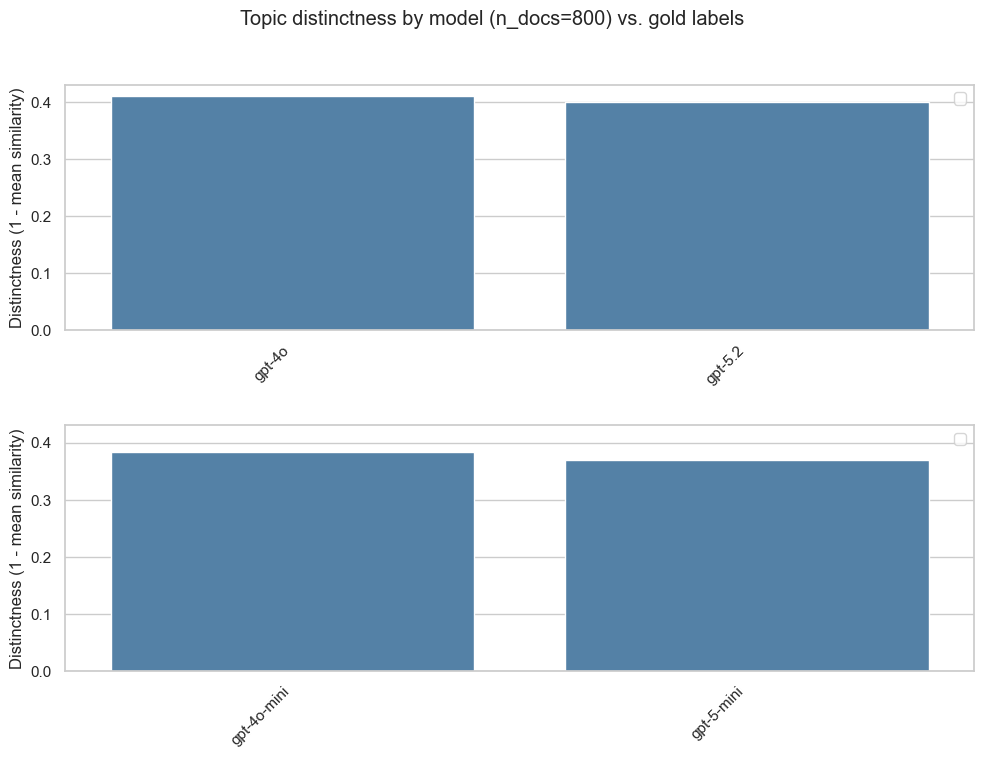

In [9]:
df_agg = df.groupby("model")["distinctness"].mean().reset_index()
# Short name: last token before _equal (e.g. Qwen3-32B, all-MiniLM-L6-v2)
df_agg["model_short"] = df_agg["model"].apply(lambda x: x.split("_")[-2] if "_" in x else x)
df_agg = df_agg.sort_values(by="distinctness", ascending=False)

n_models = len(df_agg)
n_per_row = (n_models + 2) // 3  # split into 3 rows
fig, axes = plt.subplots(3, 1, figsize=(max(10, n_per_row * 1.2), 10), sharey=True)
for i in range(3):
    start = i * n_per_row
    end = min((i + 1) * n_per_row, n_models)
    chunk = df_agg.iloc[start:end]
    ax = axes[i]
    if len(chunk) == 0:
        ax.set_visible(False)
        continue
    sns.barplot(data=chunk, x="model_short", y="distinctness", color="steelblue", ax=ax)
    if not np.isnan(gold_distinctness):
        ax.axhline(gold_distinctness, color="red", linestyle="--", label="gold distinctness")
    ax.set_ylabel("Distinctness (1 - mean similarity)")
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.legend()
axes[-1].set_xlabel("Model")
fig.suptitle(f"Topic distinctness by model (n_docs={N_DOCS}) vs. gold labels", y=1.02)
plt.tight_layout()
plt.show()

In [10]:
df_agg 

,model,distinctness,model_short
1,GenAIMethodOneShotNoPrior_800_custom_data_gpt-...,0.409717,gpt-4o
3,GenAIMethodOneShotNoPrior_800_custom_data_gpt-...,0.400128,gpt-5.2
0,GenAIMethodOneShotNoPrior_800_custom_data_gpt-...,0.383556,gpt-4o-mini
2,GenAIMethodOneShotNoPrior_800_custom_data_gpt-...,0.369226,gpt-5-mini
